<a href="https://colab.research.google.com/github/JipFlinterman/TuringMachineJip/blob/main/ProjectTMDL_Version_2-WEEK3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict house prices

We decided to get a new dataset instead of the Titanic prediction set since it was a bit too easy. Right now we are going to predict the houseprices of houses!

Loading the data

In [ ]:
#LOADING LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter

from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#LOADING TRAINING DF
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

Basic info on the df: We were checking the data for missing values and we did some checking in excel.

In [ ]:
#BASIC INFO ON THE DATA
df_train.describe()
df_train.columns
columns = list(df_train.columns)
columns_test = list(df_test.columns)

#Making list of outliers
outlier_id = []

In [ ]:
for x in columns:
  print(df_train[x].count(), x)

for y in columns_test:
  print(df_test[y].count(), y)


1460 Id
1460 MSSubClass
1460 MSZoning
1201 LotFrontage
1460 LotArea
1460 Street
91 Alley
1460 LotShape
1460 LandContour
1460 Utilities
1460 LotConfig
1460 LandSlope
1460 Neighborhood
1460 Condition1
1460 Condition2
1460 BldgType
1460 HouseStyle
1460 OverallQual
1460 OverallCond
1460 YearBuilt
1460 YearRemodAdd
1460 RoofStyle
1460 RoofMatl
1460 Exterior1st
1460 Exterior2nd
588 MasVnrType
1452 MasVnrArea
1460 ExterQual
1460 ExterCond
1460 Foundation
1423 BsmtQual
1423 BsmtCond
1422 BsmtExposure
1423 BsmtFinType1
1460 BsmtFinSF1
1422 BsmtFinType2
1460 BsmtFinSF2
1460 BsmtUnfSF
1460 TotalBsmtSF
1460 Heating
1460 HeatingQC
1460 CentralAir
1459 Electrical
1460 1stFlrSF
1460 2ndFlrSF
1460 LowQualFinSF
1460 GrLivArea
1460 BsmtFullBath
1460 BsmtHalfBath
1460 FullBath
1460 HalfBath
1460 BedroomAbvGr
1460 KitchenAbvGr
1460 KitchenQual
1460 TotRmsAbvGrd
1460 Functional
1460 Fireplaces
770 FireplaceQu
1379 GarageType
1379 GarageYrBlt
1379 GarageFinish
1460 GarageCars
1460 GarageArea
1379 GarageQual

We decided to drop a lot of data. We had like 1460 observations and decided to drop entire columns which had less than 1400 observation. This was our cutoff point.
All columns which had more than 1400 observations but less than 1460 we dropped the rows with missing values. This left us with 69 columns instead of 81 and 1412 observations instead of 1460.

In [ ]:
#FILTERING IT BY <700 => drop, >700&<1469 => dropna,
#When fillna is used, pandas automatically encodes the data
df_train_filtered = df_train
df_test_filtered = df_test

for x in columns:
    if df_train[x].count() < 700:
      df_train_filtered = df_train_filtered.drop(x, axis=1)
    elif pd.api.types.is_object_dtype(df_train[x]) or pd.api.types.is_string_dtype(df_train[x]):
      df_train_filtered[x] = df_train_filtered[x].fillna(df_train_filtered[x].mode()[0])
    elif pd.api.types.is_numeric_dtype(df_train[x]):
      df_train_filtered[x] = df_train_filtered[x].fillna(int(round(df_train_filtered[x].mean())))

for y in columns_test:
    if df_test[y].count() < 700:
      df_test_filtered = df_test_filtered.drop(y, axis=1)
    elif pd.api.types.is_object_dtype(df_test[y]) or pd.api.types.is_string_dtype(df_test[y]):
      df_test_filtered[y] = df_test_filtered[y].fillna(df_test_filtered[y].mode()[0])
    elif pd.api.types.is_numeric_dtype(df_test[y]):
      df_test_filtered[y] = df_test_filtered[y].fillna(int(round(df_test_filtered[y].mean())))

df_train_filtered.drop('Id', axis=1, inplace=True)
df_test_filtered.drop('Id', axis=1, inplace=True)

combined_data = pd.concat([df_train_filtered.drop('SalePrice', axis = 1), df_test_filtered], axis=0)
combined_data_encoded = pd.get_dummies(combined_data)

# Making everything numerical


In [ ]:
print(type(df_train_filtered["Id"].iloc[0]))

<class 'numpy.int64'>


We made everything numerical, because that will be way easier to work with while making the machine learning models. This is done by filtering on unique values and then mapping the numerical values over the original database.

In [ ]:
combined_data = pd.concat([df_train_filtered, df_test_filtered], axis=0)
unique_dict = {}

if "Id" in df_train_filtered.columns:
  df_train_filtered = df_train_filtered.drop('Id', axis=1)
if "Id" in df_test_filtered.columns:
  df_test_filtered = df_test_filtered.drop('Id', axis=1)

#making a unique values dictionary
for x in combined_data.columns:
    if pd.api.types.is_object_dtype(combined_data[x]) or pd.api.types.is_string_dtype(combined_data[x]):
        unique_dict[x] = combined_data[x].unique().tolist()

print(unique_dict)

encoded_dict = {}
#encoded_dict_test = {}

#encoding numerical values for each unique item in the dictionary
for col, values in unique_dict.items():
    encoded_dict[col] = {val: i for i, val in enumerate(values)}

print(encoded_dict)

#overmapping it
for col, mapping in encoded_dict.items():
    df_train_filtered[col] = df_train_filtered[col].map(mapping)
    df_test_filtered[col] = df_test_filtered[col].map(mapping)

df_train_filtered = df_train_filtered.fillna(0)
df_test_filtered = df_test_filtered.fillna(0)

print(df_train_filtered.head())
print(df_test_filtered.head())

{'MSZoning': ['RL', 'RM', 'C (all)', 'FV', 'RH'], 'Street': ['Pave', 'Grvl'], 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'], 'LandContour': ['Lvl', 'Bnk', 'Low', 'HLS'], 'Utilities': ['AllPub', 'NoSeWa'], 'LotConfig': ['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], 'LandSlope': ['Gtl', 'Mod', 'Sev'], 'Neighborhood': ['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst', 'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes', 'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert', 'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste'], 'Condition1': ['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe'], 'Condition2': ['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'], 'BldgType': ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], 'HouseStyle': ['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin'], 'RoofStyle': ['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], 'RoofMatl': ['CompShg'

In [ ]:
#Working on removing outliers, currently commented out due to logical misunderstandings
#Detecting Outliers (not working right, wrong thought process)
"""
df_temp = df_train_filtered.copy()

for x in df_temp.columns:
  if pd.api.types.is_numeric_dtype(df_temp[x]):
    if df_temp[x].skew() < -1 or df_temp[x].skew() > 1:
      df_temp[x] = np.log1p(df_temp[x])

    z_score = stats.zscore(df_temp[x].dropna())
    outliers = df_temp.loc[df_temp[x].dropna().index[np.abs(z_score) > 3]].index
    outlier_id.extend(outliers.tolist())

#Flattening to ensure that all data are integers
flat_outlier_ids = []

for oid in outlier_id:
    if isinstance(oid, (np.ndarray, pd.Index)):
        flat_outlier_ids.extend(oid.tolist())
    else:
        flat_outlier_ids.append(oid)

outlierz = list(set(flat_outlier_ids))
print(outlierz)
print(f"Total unique outliers: {len(outlierz)}")
"""

#Removing outlier data, if a row has multiple outlier data
"""
row_counts = Counter(flat_outlier_ids)
rows_to_remove = [row for row, count in row_counts.items() if count > 2]

df_train_filtered = df_train_filtered.drop(index=rows_to_remove, errors="ignore")
print(len(rows_to_remove))
"""

'\nrow_counts = Counter(flat_outlier_ids)\nrows_to_remove = [row for row, count in row_counts.items() if count > 2]\n\ndf_train_filtered = df_train_filtered.drop(index=rows_to_remove, errors="ignore")\nprint(len(rows_to_remove))\n'

# Which model are we using?
Right now, we are just trying to test a bunch of different models individually, nothing is concrete as of yet. We should be decided on and done optimizing the best model possible model by the next tutorial.

Individually, the XGBoost gives the best result but it is still very insufficient. We could pipeline it to linear regression or attempt to PCA to reduce dimensionality and use neural networks before feeding into a PCA. But that is still theoretical. Outlier data is still pervasive, in the worst case, we can construxt individual scatter plots and flag outlier ids using a query.

In [ ]:
# Defining y and X
y = df_train_filtered['SalePrice']
X = combined_data_encoded[:len(df_train_filtered)]
X_test = combined_data_encoded[len(df_train_filtered):]

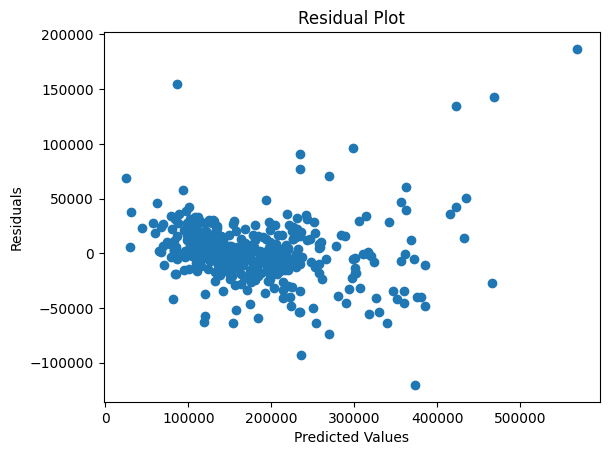

Outliers from Linear Regression training model: 12
MSE:  787998002.6194304
28071.302118345535
R2:  0.887075463641612
568240.1552004658


In [ ]:
# Splitting data into test and validation set
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, random_state=42)

# Linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)
res = y_val - y_pred

#Residual plot (Visual test for non-linearity)
plt.scatter(y_pred, res)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Predict on training set
y_pred_train = lr.predict(X_train)
res_train = y_train - y_pred_train
res_train = pd.Series(res_train, index=y_train.index)

# Trying to find outliers here instead, we need it with relation to sale price
# not just on its own
threshold = 3 * np.std(res_train)
LR_train_outliers = X_train[np.abs(res_train) > threshold]
print(f"Outliers from Linear Regression training model: {len(LR_train_outliers)}")


mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MSE: ", mse)
print(math.sqrt(mse))
print("R2: ", r2)
print(max(y_pred))

In [ ]:
#Ridge regression
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print(best_alpha)

ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)
y_pred = ridge_best.predict(X_val)
res = y_val - y_pred

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MSE: ", mse)
print(math.sqrt(mse))
print("R2: ", r2)

10
MSE:  874952150.2936343
29579.59009678184
R2:  0.8746144462558986


In [ ]:
# Lasso Regression
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lasso = Lasso(max_iter=10000)
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_estimator_.alpha
print(best_alpha)

lasso_best = Lasso(alpha=best_alpha, max_iter=10000)
lasso_best.fit(X_train, y_train)
y_pred = lasso_best.predict(X_val)
res = y_val - y_pred

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MSE: ", mse)
print(math.sqrt(mse))
print("R2: ", r2)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.507e+10, tolerance: 4.742e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.602e+10, tolerance: 4.840e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.037e+11, tolerance: 4.842e

100
MSE:  714381230.7044878
26727.91108007672
R2:  0.897625160225946


In [ ]:
# Random Forest regression
regression = RandomForestRegressor()
regression.fit(X_train,y_train)
y_pred = regression.predict(X_val)
res = y_val - y_pred

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MSE: ", mse)
print(math.sqrt(mse))
print("R2: ", r2)

MSE:  720483690.0279164
26841.82724830626
R2:  0.8967506435552776


Outliers from XGBoost training model: 17
Outliers from XGBoost validation model: 9
MSE:  724296384.0
26912.75504291599
R2:  0.8962042331695557


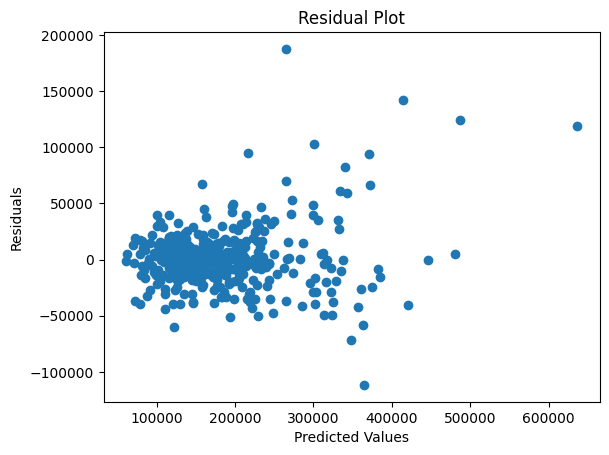

In [ ]:
# XGBoost
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
res = y_val - y_pred
residuals = pd.Series(res, index=y_val.index)

# Predict on training data
y_pred_train = xgb.predict(X_train)
res_train = y_train - y_pred_train
residuals_train = pd.Series(res_train, index=y_train.index)

# Flag training outliers
threshold = 3 * np.std(residuals_train)
train_outliers = X_train[np.abs(residuals_train) > threshold]
print(f"Outliers from XGBoost training model: {len(train_outliers)}")

# Flag outliers
threshold = 3 * np.std(residuals)
outliers = X_val[np.abs(residuals) > threshold]
print(f"Outliers from XGBoost validation model: {len(outliers)}")

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MSE: ", mse)
print(math.sqrt(mse))
print("R2: ", r2)

plt.scatter(y_pred, res)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()